In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
#from helper_functions.invertible_neural_network_positive import InvertibleNetworkSurrogate

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score#,mean_absolute_percentage_error

In [2]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [3]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [4]:
# wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [5]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

### Import test data

In [6]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_F11.h5'

In [7]:
dvar_test = pd.read_hdf(test_datafile, key = 'dvar')
qoi_test = pd.read_hdf(test_datafile, key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [8]:
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
1      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
2      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
3      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
4      6.868667  6.848986  6.828374  6.806935  6.784763  6.761942  6.738547   
...         ...       ...       ...       ...       ...       ...       ...   
19464  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19465  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19466  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19467  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19468  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163  \
0      2.343187  2.246660  2.150146  ... -1.609248 -1.607157 -1.604971   
1      0.820055  0.677661  0.542517  ... -2.203292 -2.203016 -2.202694   
2      4.427529  4.389708  4.349729  ...  0.445481  0.447236  0.449890   
3      4.476688  4.386768  4.298978  ...  1.365336  1.367517  1.369768   
4      6.714646  6.690300  6.665563  ...  5.304904  5.308211  5.311385   
...         ...       ...       ...  ...       ...       ...       ...   
19464  8.557358  8.496452  8.435355  ...  4.551540  4.552671  4.553839   
19465  2.331944  2.303737  2.273986  ... -1.354982 -1.351174 -1.347418   
19466  2.778518  2.680291  2.583919  ... -0.587551 -0.585725 -0.583797   
19467  7.956617  7.857872  7.762334  ...  4.529373  4.532410  4.535440   
19468  5.152917  5.109587  5.066588  ...  2.838069  2.841063  2.843975   

        F11_164   F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0     -1.602709 -1.600392 -1.598040 -1.595679 -1.593335 -1.591034 -1.588804  
1     -2.202328 -2.201920 -2.201469 -2.200978 -2.200450 -2.199891 -2.199311  
2      0.453303  0.457339  0.461859  0.466726  0.471807  0.476977  0.482116  
3      1.372076  1.374424  1.376792  1.379162  1.381512  1.383817  1.386053  
4      5.314421  5.317310  5.320048  5.322626  5.325041  5.327285  5.329353  
...         ...       ...       ...       ...       ...       ...       ...  
19464  4.555031  4.556238  4.557447  4.558647  4.559824  4.560967  4.562063  
19465 -1.343736 -1.340148 -1.336676 -1.333341 -1.330162 -1.327160 -1.324352  
19466 -0.581781 -0.579693 -0.577552 -0.575378 -0.573194 -0.571026 -0.568901  
19467  4.538444  4.541404  4.544300  4.547115  4.549827  4.552419  4.554870  
19468  2.846796  2.849513  2.852116  2.854594  2.856936  2.859134  2.861176  

[19469 rows x 152 columns]

In [9]:
# Process F11 and PPF for the plots --> np.exp(F11)

F11_list = [x for x in qoi_test.columns if 'F11' in x]
PPF_list = [x for x in qoi_test.columns if 'PPF' in x]

qoi_test_plot = qoi_test.copy()
qoi_test_plot[F11_list] = np.exp(qoi_test_plot[F11_list])
qoi_test_plot[PPF_list] = (qoi_test_plot[PPF_list])

In [10]:
# Process the state parameters to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_test_plot = dvar_test.copy()
dvar_test_plot['Vtot'] = np.exp(dvar_test['Vtot'])
dvar_test_plot['RmedianV'] = np.exp(dvar_test['RmedianV'])
dvar_test_plot['GSD'] = np.exp(dvar_test['GSD'])+1
dvar_test_plot['n'] = np.exp(dvar_test['n'])+1.33
dvar_test_plot['k'] = np.exp(dvar_test['k'])

### Load the model to test

In [11]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

# Model directory
directory = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/invertible_models_iv1_F11'
model_dir = directory + '/models'

# Plot directory (subdirectory of the model)
plot_dir = model_dir +'/plots/test_data_original/'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [12]:
custom_objects = {'AdjustedRSquared':AdjustedRSquared}

kwargs = {'custom_objects':custom_objects, 'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

#### Forward prediction

In [13]:
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)


print('Time for the forward prediction: %i s' %dt)

Time for the forward prediction: 1 s


In [14]:
# Process the data for the plots --> np.exp(F11)

F11_list = [x for x in qoi_pred_fw.columns if 'F11' in x]
PPF_list = [x for x in qoi_pred_fw.columns if 'PPF' in x]

qoi_pred_fw_plot = qoi_pred_fw.copy()
qoi_pred_fw_plot[F11_list] = np.exp(qoi_pred_fw_plot[F11_list])
qoi_pred_fw_plot[PPF_list] = (qoi_pred_fw_plot[PPF_list])

#### Inverse prediction

In [15]:
start = time.time()
dvar_pred_iv_original = surr.sample_n_tries(qoi_test.values, batch_size = 8, n_tries = 1)
end = time.time()
dt = (end-start)#/len(dvar_test)

dvar_pred_iv = pd.DataFrame(data = dvar_pred_iv_original, columns = dvar_test.columns)

print('Time for the inverse prediction: %i s' %dt)

Time for the inverse prediction: 32 s


In [16]:
# Process the data to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_pred_iv_plot = dvar_pred_iv.copy()
dvar_pred_iv_plot['Vtot'] = np.exp(dvar_pred_iv_plot['Vtot'])
dvar_pred_iv_plot['RmedianV'] = np.exp(dvar_pred_iv_plot['RmedianV'])
dvar_pred_iv_plot['GSD'] = np.exp(dvar_pred_iv_plot['GSD'])+1
dvar_pred_iv_plot['n'] = np.exp(dvar_pred_iv_plot['n'])+1.33
dvar_pred_iv_plot['k'] = np.exp(dvar_pred_iv_plot['k'])

### Metrics forward step

In [17]:
qoi_test_copy = qoi_test_plot.copy()
qoi_pred_fw_copy  = qoi_pred_fw_plot.copy()

#### 1. R2 - forward step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [18]:
# Define which metric to use
metric_fw = RSquaredSeparated() # separated means that it is calculated for each variable

r2_fw = metric_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_fw = pd.Series(data=r2_fw, index=qoi_columns)
r2_fw = np.round(r2_fw, decimals=2)
r2_fw = pd.DataFrame(r2_fw).T

print('Forward model: R2_min = %.2f ; R2_max = %.2f ; R2_mean = %.2f '
      % (r2_fw.mean(axis=1), min(r2_fw.min()), max(r2_fw.max())))

Forward model: R2_min = 0.98 ; R2_max = 0.96 ; R2_mean = 1.00 


In [19]:
# List the 10 points with the lowest R2
r2_fw.sort_values(by=r2_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_170  F11_147  F11_167  F11_169  F11_56  F11_136  F11_151  F11_135  \
0     0.96     0.96     0.96     0.96    0.96     0.97     0.97     0.97   

   F11_57  F11_46  
0    0.97    0.97

#### 2. Adjusted R2 - forward step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [20]:
# Define which metric to use
metric2_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_fw = metric2_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T

print('Forward model: R2adj_mean = %.2f  ;  R2adj_min = %.2f  ;  R2adj_max = %.2f '
      % (r2_adj_fw.mean(axis=1), min(r2_adj_fw.min()), max(r2_adj_fw.max())))

Forward model: R2adj_mean = 0.98  ;  R2adj_min = 0.96  ;  R2adj_max = 1.00 


In [21]:
# List the 10 points with the lowest adjR2
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_170  F11_147  F11_169  F11_56  F11_167  F11_165  F11_121  F11_168  \
0     0.96     0.96     0.96    0.96     0.96     0.97     0.97     0.97   

   F11_136  F11_135  
0     0.97     0.97

#### 3. Absolute error - forward step

absolute_error = $|y_{true}-y_{pred}|$

In [22]:
abs_error_fw = np.abs(qoi_test_copy - qoi_pred_fw_copy)

In [23]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [24]:
abs_error_table_fw.sort_values(by=abs_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

F11_10  F11_13  F11_14  F11_11  F11_12  F11_16  F11_17  F11_15  F11_21  \
50%     4.03    2.55    2.47    3.82    3.08    2.06    1.94    1.80    1.14   
75%    42.01   30.30   28.24   36.11   32.21   23.79   21.21   19.30   14.50   
90%   215.93  166.07  161.86  171.18  157.89  127.22  115.58  109.65   92.60   
95%   427.39  334.54  329.05  326.25  312.72  250.08  243.77  240.74  207.94   
99%  1230.89  810.92  878.95  784.91  793.74  624.99  678.65  669.72  554.44   

     F11_20  
50%    1.31  
75%   15.98  
90%   91.00  
95%  202.60  
99%  530.02

In [25]:
abs_error_table_fw_F11 = abs_error_table_fw[F11_list]
print('Absolute error F11:')
print(abs_error_table_fw_F11.max(axis = 1))
print('\n')

abs_error_table_fw_PPF = abs_error_table_fw[PPF_list]
print('Absolute error PPF:')
print(abs_error_table_fw_PPF.max(axis = 1))
print('\n')


Absolute error F11:
50%       4.03
75%      42.01
90%     215.93
95%     427.39
99%    1230.89
dtype: float64


Absolute error PPF:
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64




#### 4. Relative error - forward step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [26]:
rel_error_fw = abs_error_fw / (qoi_test_copy) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [27]:
rel_error_table_fw =  np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [28]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

F11_158  F11_147  F11_170  F11_167  F11_10  F11_169  F11_97  F11_161  \
50%     6.86     9.62     6.63     6.59    3.88     6.62    7.08     6.41   
75%    12.34    13.74    11.11    10.77    6.57    10.73   10.80    10.45   
90%    18.07    17.73    15.56    14.96   11.69    14.75   14.45    14.38   
95%    21.45    20.23    18.55    17.96   17.87    17.66   17.03    16.97   
99%    30.92    26.69    35.83    32.86   36.08    38.27   24.28    27.30   

     F11_166  F11_115  
50%     6.06     5.92  
75%     9.85     9.84  
90%    13.74    13.47  
95%    16.78    16.16  
99%    33.56    22.79

In [29]:
rel_error_table_fw_F11 = rel_error_table_fw[F11_list]
print('Relative error F11:')
print(rel_error_table_fw_F11.max(axis=1))
print('\n')

rel_error_table_fw_PPF = rel_error_table_fw[PPF_list]
print('Relative error PPF:')
print(rel_error_table_fw_PPF.max(axis=1))

Relative error F11:
50%     9.62
75%    13.74
90%    18.07
95%    21.45
99%    38.27
dtype: float64


Relative error PPF:
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


#### 5. wMAPE - forward step

In [30]:
wMAPE_fw = wmape(qoi_test_copy, qoi_pred_fw_copy)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T

In [31]:
wMAPE_fw.sort_values(by=wMAPE_fw.index[0], axis=1, ascending=False).iloc[:, :10]

F11_147    F11_170    F11_167    F11_104    F11_161    F11_151    F11_121  \
0  15.8836  13.239868  12.680342  12.418529  12.380838  12.363865  12.328196   

     F11_169    F11_136    F11_101  
0  12.195625  12.076833  11.737676

In [32]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 8.338


In [33]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: nan


### Metrics inverse step

In [34]:
dvar_test_copy = dvar_test.copy()
dvar_pred_iv_copy = dvar_pred_iv.copy()

#### 1. R2 - inverse step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [35]:
# Define which metric to use
metric_iv = RSquaredSeparated() # separated means that it is calculated for each variable

r2_iv = metric_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_iv = pd.Series(data=r2_iv, index=dvar_columns)
r2_iv = np.round(r2_iv, decimals=2)
r2_iv = pd.DataFrame(r2_iv).T

print('Inverse model: R2_mean = %.2f ; R2_min = %.2f ; R2_max = %.2f '
      % (r2_iv.mean(axis=1), min(r2_iv.min()), max(r2_iv.max())))

Inverse model: R2_mean = 0.91 ; R2_min = 0.66 ; R2_max = 1.00 


In [36]:
# List the 10 points with the lowest R2
r2_iv.sort_values(by=r2_iv.index[0], axis=1, ascending=True)

n     k   GSD  RmedianV  Vtot
0  0.66  0.91  0.98      0.99   1.0

#### 2. Adjusted R2 - inverse step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [37]:
# Define which metric to use
metric2_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_iv = metric2_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T

print('Inverse model: R2adj_mean = %.2f  ;  R2adj_min = %.2f  ;  R2adj_max = %.2f '
      % (r2_adj_iv.mean(axis=1), min(r2_adj_iv.min()), max(r2_adj_iv.max())))

Inverse model: R2adj_mean = 0.91  ;  R2adj_min = 0.66  ;  R2adj_max = 1.00 


In [38]:
# List the 10 points with the lowest adjR2
r2_adj_iv.sort_values(by=r2_adj_iv.index[0], axis=1, ascending=True).iloc[:, :10]

n     k   GSD  RmedianV  Vtot
0  0.66  0.91  0.98      0.99   1.0

#### 3. Absolute error - inverse step

absolute_error = $|y_{true}-y_{pred}|$

In [39]:
abs_error_iv = np.abs(dvar_test_copy - dvar_pred_iv_copy)

In [40]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [41]:
abs_error_table_iv.sort_values(by=abs_error_table_iv.index[3], axis=1, ascending=False)

n     k  Vtot   GSD  RmedianV
50%  0.16  0.08  0.05  0.04      0.02
75%  0.38  0.18  0.10  0.07      0.06
90%  0.76  0.38  0.20  0.13      0.13
95%  1.14  0.56  0.29  0.20      0.19
99%  2.45  1.21  0.48  0.56      0.32

In [42]:
print('Inverse model: mean abs. error \n')
print(abs_error_iv.mean())

Inverse model: mean abs. error 

Vtot        0.083160
RmedianV    0.049618
GSD         0.066697
n           0.320859
k           0.160355
dtype: float64


In [43]:
print('Inverse model: max abs. error \n')
print(abs_error_iv.max())

Inverse model: max abs. error 

Vtot        3.117911
RmedianV    1.075909
GSD         1.844509
n           9.405589
k           6.517107
dtype: float64


#### 4. Relative error - inverse step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [44]:
rel_error_iv = abs_error_iv / (dvar_test_copy) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [45]:
rel_error_table_iv =  np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [46]:
rel_error_table_iv.sort_values(by=rel_error_table_iv.index[3], axis=1, ascending=False)

n        k     GSD    Vtot  RmedianV
50%    39.54    16.06    9.06    1.34      0.40
75%    91.35    49.24   21.94    3.54      0.87
90%   207.26   142.29   57.21   10.53      1.78
95%   394.59   293.75  113.94   22.68      2.49
99%  1907.33  1614.51  588.87  104.04      4.21

In [47]:
print('Inverse model: mean rel error in % \n')
print(rel_error_iv.mean())

Inverse model: mean rel error in % 

Vtot         10.914288
RmedianV      0.704875
GSD          57.089094
n           203.506503
k           181.982710
dtype: float64


In [48]:
print('Inverse model: max rel error in % \n')
print(rel_error_iv.max())

Inverse model: max rel error in % 

Vtot        1.929720e+04
RmedianV    1.450443e+01
GSD         6.894020e+04
n           1.831243e+05
k           1.020420e+06
dtype: float64


#### 5. wMAPE - inverse step

In [49]:
wMAPE_iv = wmape(dvar_test_copy, dvar_pred_iv_copy)
wMAPE_iv = pd.DataFrame(wMAPE_iv).T

In [50]:
wMAPE_iv.sort_values(by=wMAPE_iv.index[0], axis=1, ascending=False)

n          k        GSD      Vtot  RmedianV
0  44.644096  23.290136  10.961739  1.966751  0.757723

In [51]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 8.338


In [52]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: nan


### Performance summary

In [53]:
performance = pd.DataFrame(columns = ['F11','PPF','Vtot','RmedianV','GSD','n','k'])

performance.loc['r2']= [r2_fw[F11_list].mean(axis=1)[0],
                        r2_fw[PPF_list].mean(axis=1)[0],
                        r2_iv['Vtot'][0],
                        r2_iv['RmedianV'][0],
                        r2_iv['GSD'][0],
                        r2_iv['n'][0],
                        r2_iv['k'][0]
                       ]

#performance.loc['R2adj']= [r2_adj_fw[F11_list].mean(axis=1)[0],
#                            r2_adj_fw[PPF_list].mean(axis=1)[0],
#                            r2_adj_iv['Vtot'][0],
#                            r2_adj_iv['RmedianV'][0],
#                            r2_adj_iv['GSD'][0],
#                            r2_adj_iv['n'][0],
#                            r2_adj_iv['k'][0]
#                           ]
performance.loc['max_abs_err_90%']= [abs_error_table_fw_F11.max(axis = 1)['90%'],
                                     abs_error_table_fw_PPF.max(axis = 1)['90%'],
                                     abs_error_table_iv.loc['90%']['Vtot'],
                                     abs_error_table_iv.loc['90%']['RmedianV'],
                                     abs_error_table_iv.loc['90%']['GSD'],
                                     abs_error_table_iv.loc['90%']['n'],
                                     abs_error_table_iv.loc['90%']['k']
                                    ]


performance.loc['max_abs_err_95%']= [abs_error_table_fw_F11.max(axis = 1)['95%'],
                                     abs_error_table_fw_PPF.max(axis = 1)['95%'],
                                     abs_error_table_iv.loc['95%']['Vtot'],
                                     abs_error_table_iv.loc['95%']['RmedianV'],
                                     abs_error_table_iv.loc['95%']['GSD'],
                                     abs_error_table_iv.loc['95%']['n'],
                                     abs_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['max_rel_err_90%']= [rel_error_table_fw_F11.max(axis = 1)['90%'],
                                     rel_error_table_fw_PPF.max(axis = 1)['90%'],
                                     rel_error_table_iv.loc['90%']['Vtot'],
                                     rel_error_table_iv.loc['90%']['RmedianV'],
                                     rel_error_table_iv.loc['90%']['GSD'],
                                     rel_error_table_iv.loc['90%']['n'],
                                     rel_error_table_iv.loc['90%']['k']
                                    ]


performance.loc['max_rel_err_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],
                                     rel_error_table_fw_PPF.max(axis = 1)['95%'],
                                     rel_error_table_iv.loc['95%']['Vtot'],
                                     rel_error_table_iv.loc['95%']['RmedianV'],
                                     rel_error_table_iv.loc['95%']['GSD'],
                                     rel_error_table_iv.loc['95%']['n'],
                                     rel_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['wMAPE']= [wMAPE_fw[F11_list].mean().mean(),
                           wMAPE_fw[PPF_list].mean().mean(),
                           wMAPE_iv['Vtot'][0],
                           wMAPE_iv['RmedianV'][0],
                           wMAPE_iv['GSD'][0],
                           wMAPE_iv['n'][0],
                           wMAPE_iv['k'][0]
                          ]

#performance.loc['rel_err_max_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],rel_error_table_fw_PPF.max(axis = 1)['95%'],rel_error_table_iv.loc['95%'].values[0],rel_error_table_iv.loc['95%'].values[1],rel_error_table_iv.loc['95%'].values[2],rel_error_table_iv.loc['95%'].values[3],rel_error_table_iv.loc['95%'].values[4]]
#performance.loc['wmape']= [,,,,,,]



In [54]:
performance = performance.round(decimals = 2)
performance

F11  PPF   Vtot  RmedianV     GSD       n       k
r2                 0.98  NaN   1.00      0.99    0.98    0.66    0.91
max_abs_err_90%  215.93  NaN   0.20      0.13    0.13    0.76    0.38
max_abs_err_95%  427.39  NaN   0.29      0.19    0.20    1.14    0.56
max_rel_err_90%   18.07  NaN  10.53      1.78   57.21  207.26  142.29
max_rel_err_95%   21.45  NaN  22.68      2.49  113.94  394.59  293.75
wMAPE              8.34  NaN   1.97      0.76   10.96   44.64   23.29

In [55]:
performance.to_csv(f'{plot_dir}/iv_error_df.csv')

### Plot for validation vs predicted values

In [56]:
index_list = [100, 1000, 10000]

In [57]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles_plot = np.concatenate([angles1, angles2])

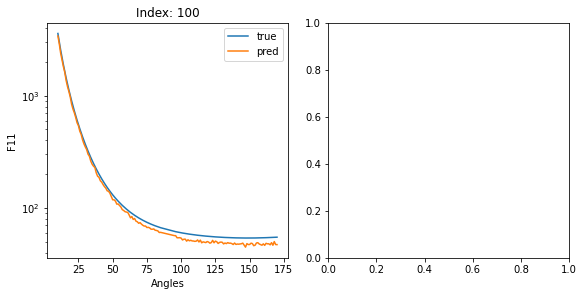

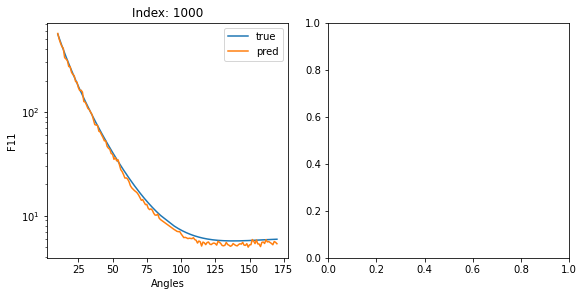

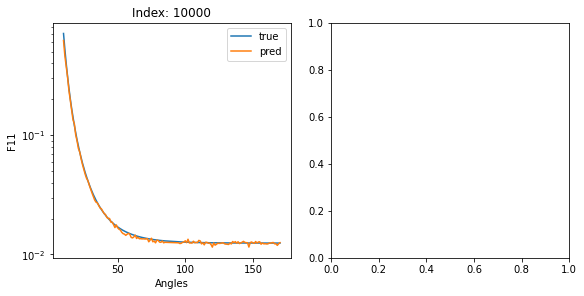

In [59]:
for idx in index_list:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

    axs[0].set_title('Index: %i' %idx)
    axs[0].plot(angles_plot, qoi_test_plot[F11_list].iloc[idx], c='C0', label = 'true')
    axs[0].plot(angles_plot, qoi_pred_fw_plot[F11_list].iloc[idx], c='C1', label = 'pred')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Angles')
    axs[0].set_ylabel('F11')
    axs[0].legend()
  #  axs[1].plot(angles_plot, qoi_test_plot[PPF_list].iloc[idx], c='C0', label = 'true')
  #  axs[1].plot(angles_plot, qoi_pred_fw_plot[PPF_list].iloc[idx], c='C1', label = 'pred')
  #  axs[1].set_ylim(-1, 1)
  #  axs[1].set_xlabel('Angles')
  #  axs[1].set_ylabel('PPF')
  #  axs[1].legend()
    fig.savefig(f'{plot_dir}/PF_PPF_pred_index_'+str(idx)+'.jpg')

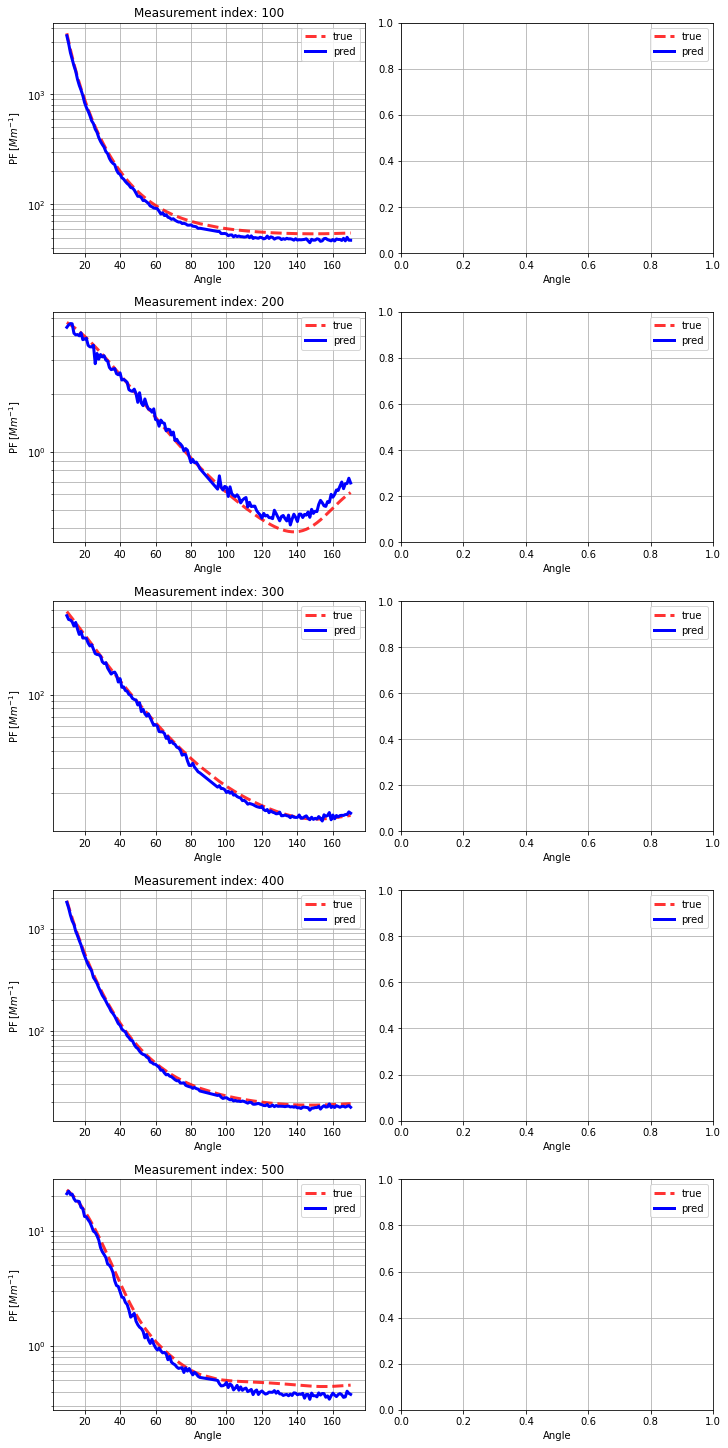

In [60]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(angles_plot, qoi_test_plot[F11_list].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
  #  pms_hdf_plot, = axs[nr,1].plot(angles_plot, qoi_test_plot[PPF_list].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(angles_plot, qoi_pred_fw_plot[F11_list].loc[index],ls = '-',lw ='3', c= 'b', label = 'pred')
   # meas_hdf_plot, = axs[nr,1].plot(angles_plot, qoi_pred_fw_plot[PPF_list].loc[index],ls = '-',lw = '3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
   # axs[nr,1].set_ylabel('PPF [-]')
   # axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')

In [61]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [62]:
dvar_test_plot

Vtot     RmedianV       GSD         n         k
0         4.953045   447.099789  1.687354  2.622790  0.754203
1         9.853527  2953.110936  2.635387  2.087974  1.787399
2        27.700011   254.587570  1.044152  2.913697  1.101197
3        49.011526   519.446422  2.185569  2.364048  2.055679
4       441.427213   100.471110  2.205250  2.883629  1.983418
...            ...          ...       ...       ...       ...
19464  2902.889066   244.818462  2.048755  1.459021  0.468698
19465     3.793219   204.348275  1.206468  1.562014  1.081841
19466     8.990683   528.078164  1.949690  2.689447  1.873984
19467  2367.063858   780.091790  2.555797  2.806807  0.538075
19468    84.401659   168.632644  2.579873  2.563342  1.104086

[19469 rows x 5 columns]

In [63]:
dvar_test_plot['DmedianV']=dvar_test_plot['RmedianV']*2*1e-3 #[um]
dvar_test_plot['DmedianN']=(np.exp(np.log(dvar_test_plot['DmedianV']) - (3*np.log(dvar_test_plot['GSD'])**2))) *1e3   #[nm]
dvar_test_plot['Ntot'] = 6 / np.pi * dvar_test_plot['Vtot']*1e9 / (np.exp((3*np.log(dvar_test_plot['DmedianN'])) + (4.5*np.log(dvar_test_plot['GSD'])**2))) # [cm^-3]
 

In [64]:
dvar_pred_iv_plot

Vtot     RmedianV       GSD         n         k
0         5.116359   435.411397  1.656026  2.329290  0.868691
1        10.341066  3150.053424  2.712070  1.908554  1.941786
2        26.303338   247.711671  1.042410  2.859184  0.965711
3        50.927462   522.675741  2.154201  2.276274  2.212087
4       457.850282    96.204106  2.255054  2.188513  2.138180
...            ...          ...       ...       ...       ...
19464  2842.690180   244.502874  1.965541  1.464723  0.493942
19465     3.770670   212.804323  1.214055  1.818255  0.925891
19466     9.032363   525.570182  1.949281  2.054010  2.056580
19467  2381.010546   752.378522  2.523427  2.738374  0.593261
19468    83.987329   175.406540  2.466537  2.629676  1.176523

[19469 rows x 5 columns]

In [65]:
dvar_pred_iv_plot['DmedianV']=dvar_pred_iv_plot['RmedianV']*2*1e-3 #[um]
dvar_pred_iv_plot['DmedianN']=(np.exp(np.log(dvar_pred_iv_plot['DmedianV']) - (3*np.log(dvar_pred_iv_plot['GSD'])**2))) *1e3   #[nm]
dvar_pred_iv_plot['Ntot'] = 6 / np.pi * dvar_pred_iv_plot['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred_iv_plot['DmedianN'])) + (4.5*np.log(dvar_pred_iv_plot['GSD'])**2))) # [cm^-3]


In [66]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

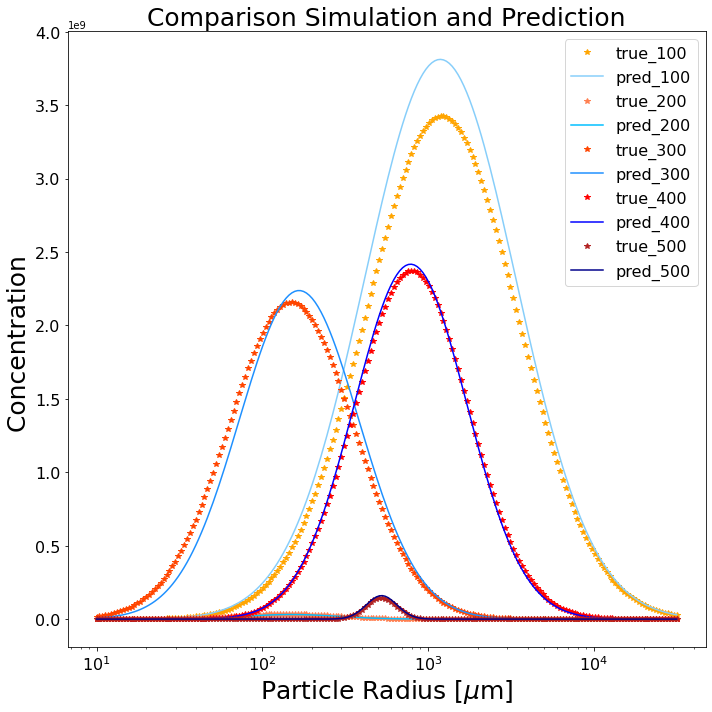

In [67]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']
j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test_plot['DmedianN'].loc[i], dvar_test_plot['GSD'].loc[i], dvar_test_plot['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred_iv_plot['DmedianN'].loc[i], dvar_pred_iv_plot['GSD'].loc[i], dvar_pred_iv_plot['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    

        #ax.legend(['Predicted test data', 'test data'], fontsize = 16)
    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')